In [1]:
%%time
import sagemaker
from sagemaker import get_execution_role

role = get_execution_role()
print(role)
sess = sagemaker.Session()

arn:aws:iam::163964939009:role/service-role/AmazonSageMaker-ExecutionRole-20180712T201302
CPU times: user 720 ms, sys: 140 ms, total: 860 ms
Wall time: 1.3 s


In [2]:
#bucket = '<your_s3_bucket_name_here>' # custom bucket name.
bucket = sess.default_bucket()
prefix = 'DEMO-ObjectDetection'

INFO:sagemaker:Created S3 bucket: sagemaker-us-east-1-163964939009


In [3]:
from sagemaker.amazon.amazon_estimator import get_image_uri

training_image = get_image_uri(sess.boto_region_name, 'object-detection', repo_version="latest")
print (training_image)

811284229777.dkr.ecr.us-east-1.amazonaws.com/object-detection:latest


In [4]:
import os
import urllib.request

def download(url):
    filename = url.split("/")[-1]
    if not os.path.exists(filename):
        urllib.request.urlretrieve(url, filename)


# MSCOCO validation image files
download('http://images.cocodataset.org/zips/val2017.zip')
download('http://images.cocodataset.org/annotations/annotations_trainval2017.zip')

In [6]:
%%bash
unzip -qo val2017.zip
unzip -qo annotations_trainval2017.zip
rm val2017.zip annotations_trainval2017.zip

unzip:  cannot find or open val2017.zip, val2017.zip.zip or val2017.zip.ZIP.
unzip:  cannot find or open annotations_trainval2017.zip, annotations_trainval2017.zip.zip or annotations_trainval2017.zip.ZIP.
rm: cannot remove ‘val2017.zip’: No such file or directory
rm: cannot remove ‘annotations_trainval2017.zip’: No such file or directory


In [7]:
%%bash
#Create folders to store the data and annotation files
mkdir generated train train_annotation validation validation_annotation

In [8]:
import json
import logging

def get_coco_mapper():
    original_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20,
                    21, 22, 23, 24, 25, 27, 28, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40,
                    41, 42, 43, 44, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60,
                    61, 62, 63, 64, 65, 67, 70, 72, 73, 74, 75, 76, 77, 78, 79, 80,
                    81, 82, 84, 85, 86, 87, 88, 89, 90]
    iter_counter = 0
    COCO = {}
    for orig in original_list:
        COCO[orig] = iter_counter
        iter_counter += 1
    return COCO

In [9]:
def get_mapper_fn(map):  
    def mapper(in_category):
        return map[in_category]
    return mapper

fix_index_mapping = get_mapper_fn(get_coco_mapper())

In [10]:
file_name = './annotations/instances_val2017.json'
with open(file_name) as f:
    js = json.load(f)
    images = js['images']
    categories = js['categories']
    annotations = js['annotations']
    for i in images:
        jsonFile = i['file_name']
        jsonFile = jsonFile.split('.')[0]+'.json'
        
        line = {}
        line['file'] = i['file_name']
        line['image_size'] = [{
            'width':int(i['width']),
            'height':int(i['height']),
            'depth':3
        }]
        line['annotations'] = []
        line['categories'] = []
        for j in annotations:
            if j['image_id'] == i['id'] and len(j['bbox']) > 0:
                line['annotations'].append({
                    'class_id':int(fix_index_mapping(j['category_id'])),
                    'top':int(j['bbox'][1]),
                    'left':int(j['bbox'][0]),
                    'width':int(j['bbox'][2]),
                    'height':int(j['bbox'][3])
                })
                class_name = ''
                for k in categories:
                    if int(j['category_id']) == k['id']:
                        class_name = str(k['name'])
                assert class_name is not ''
                line['categories'].append({
                    'class_id':int(j['category_id']),
                    'name':class_name
                })
        if line['annotations']:
            with open(os.path.join('generated', jsonFile),'w') as p:
                json.dump(line,p)

In [11]:
import os
import json
jsons = os.listdir('generated')

print ('There are {} images have annotation files'.format(len(jsons)))

There are 4952 images have annotation files


In [12]:
import shutil

train_jsons = jsons[:4452]
val_jsons = jsons[4452:]

#Moving training files to the training folders
for i in train_jsons:
    image_file = './val2017/'+i.split('.')[0]+'.jpg'
    shutil.move(image_file, './train/')
    shutil.move('./generated/'+i, './train_annotation/')

#Moving validation files to the validation folders
for i in val_jsons:
    image_file = './val2017/'+i.split('.')[0]+'.jpg'
    shutil.move(image_file, './validation/')
    shutil.move('./generated/'+i, './validation_annotation/')

In [13]:
%%time

train_channel = prefix + '/train'
validation_channel = prefix + '/validation'
train_annotation_channel = prefix + '/train_annotation'
validation_annotation_channel = prefix + '/validation_annotation'

sess.upload_data(path='train', bucket=bucket, key_prefix=train_channel)
sess.upload_data(path='validation', bucket=bucket, key_prefix=validation_channel)
sess.upload_data(path='train_annotation', bucket=bucket, key_prefix=train_annotation_channel)
sess.upload_data(path='validation_annotation', bucket=bucket, key_prefix=validation_annotation_channel)

s3_train_data = 's3://{}/{}'.format(bucket, train_channel)
s3_validation_data = 's3://{}/{}'.format(bucket, validation_channel)
s3_train_annotation = 's3://{}/{}'.format(bucket, train_annotation_channel)
s3_validation_annotation = 's3://{}/{}'.format(bucket, validation_annotation_channel)

CPU times: user 51.7 s, sys: 5.14 s, total: 56.8 s
Wall time: 9min 13s


In [14]:
s3_output_location = 's3://{}/{}/output'.format(bucket, prefix)

In [15]:
od_model = sagemaker.estimator.Estimator(training_image,
                                         role, 
                                         train_instance_count=1, 
                                         train_instance_type='ml.p3.2xlarge',
                                         train_volume_size = 50,
                                         train_max_run = 360000,
                                         input_mode = 'File',
                                         output_path=s3_output_location,
                                         sagemaker_session=sess)

In [24]:
od_model.set_hyperparameters(base_network='resnet-50',
                             use_pretrained_model=1,
                             num_classes=80,
                             mini_batch_size=16,
                             epochs=1,
                             learning_rate=0.001,
                             lr_scheduler_step='10',
                             lr_scheduler_factor=0.1,
                             optimizer='sgd',
                             momentum=0.9,
                             weight_decay=0.0005,
                             overlap_threshold=0.5,
                             nms_threshold=0.45,
                             image_shape=512,
                             label_width=350,
                             num_training_samples=4452)

In [25]:
train_data = sagemaker.session.s3_input(s3_train_data, distribution='FullyReplicated', 
                        content_type='image/jpeg', s3_data_type='S3Prefix')
validation_data = sagemaker.session.s3_input(s3_validation_data, distribution='FullyReplicated', 
                             content_type='image/jpeg', s3_data_type='S3Prefix')
train_annotation = sagemaker.session.s3_input(s3_train_annotation, distribution='FullyReplicated', 
                             content_type='image/jpeg', s3_data_type='S3Prefix')
validation_annotation = sagemaker.session.s3_input(s3_validation_annotation, distribution='FullyReplicated', 
                             content_type='image/jpeg', s3_data_type='S3Prefix')

data_channels = {'train': train_data, 'validation': validation_data, 
                 'train_annotation': train_annotation, 'validation_annotation':validation_annotation}

In [26]:
od_model.fit(inputs=data_channels, logs=True)

INFO:sagemaker:Creating training-job with name: object-detection-2018-07-20-10-28-59-064


...............................
Docker entrypoint called with argument(s): train
[07/20/2018 10:34:03 INFO 140299457333056] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'lr_scheduler_step': u'', u'weight_decay': u'0.0005', u'optimizer': u'sgd', u'_tuning_objective_metric': u'', u'base_network': u'vgg-16', u'freeze_layer_pattern': u'', u'use_pretrained_model': u'0', u'_kvstore': u'device', u'label_width': u'350', u'kv_store': u'device', u'epochs': u'30', u'nms_threshold': u'0.45', u'momentum': u'0.9', u'overlap_threshold': u'0.5', u'lr_scheduler_factor': u'0.1', u'image_shape': u'300', u'_num_kv_servers': u'auto', u'mini_batch_size': u'32', u'learning_rate': u'0.001', u'num_classes': u'', u'num_training_samples': u''}
[07/20/2018 10:34:03 INFO 140299457333056] Reading provided configuration from /opt/ml/input/config/hyperparameters.json: {u'lr_scheduler_step': u'10', u'weight_decay': u'0.0005', u'mini_batch_size': u'16', u'op

===== Job Complete =====
Billable seconds: 365


In [27]:
object_detector = od_model.deploy(initial_instance_count = 1,
                                 instance_type = 'ml.m4.xlarge')

INFO:sagemaker:Creating model with name: object-detection-2018-07-20-10-37-13-874
INFO:sagemaker:Creating endpoint with name object-detection-2018-07-20-10-28-59-064


---------------------------------------------------------------!

In [28]:
!wget -O test.jpg https://images.pexels.com/photos/980382/pexels-photo-980382.jpeg
file_name = 'test.jpg'

with open(file_name, 'rb') as image:
    f = image.read()
    b = bytearray(f)
    ne = open('n.txt','wb')
    ne.write(b)

--2018-07-20 10:42:32--  https://images.pexels.com/photos/980382/pexels-photo-980382.jpeg
Resolving images.pexels.com (images.pexels.com)... 104.16.239.112, 104.16.240.112, 104.16.241.112, ...
Connecting to images.pexels.com (images.pexels.com)|104.16.239.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1836911 (1.8M) [image/jpeg]
Saving to: ‘test.jpg’

test.jpg            100%[===================>]   1.75M  --.-KB/s    in 0.05s   

2018-07-20 10:42:33 (35.7 MB/s) - ‘test.jpg’ saved [1836911/1836911]



In [29]:
import json

object_detector.content_type = 'image/jpeg'
results = object_detector.predict(b)
detections = json.loads(results)
print (detections)

{'prediction': [[0.0, 0.28875860571861267, 0.4079148769378662, 0.28403812646865845, 0.8282968997955322, 0.9916955828666687], [0.0, 0.23922041058540344, 0.5244383215904236, 0.5312058925628662, 0.572661817073822, 0.6383273601531982], [0.0, 0.22272613644599915, 0.7436789274215698, 0.5691877603530884, 0.7917658090591431, 0.6692825555801392], [0.0, 0.2056838572025299, 0.6511686444282532, 0.43876227736473083, 0.7789127230644226, 0.7596769332885742], [0.0, 0.19050981104373932, 0.6868557929992676, 0.19796612858772278, 1.0, 1.0], [0.0, 0.17660115659236908, 0.4914483428001404, 0.6886894106864929, 0.5411829352378845, 0.7863406538963318], [0.0, 0.1732054203748703, 0.3040789067745209, 0.5312085151672363, 0.3552893102169037, 0.6384599208831787], [0.0, 0.1712542325258255, 0.24960123002529144, 0.6082952618598938, 0.2890581786632538, 0.6977371573448181], [0.0, 0.1679643988609314, 0.15288029611110687, 0.29454129934310913, 0.5667814016342163, 0.9549689888954163], [0.0, 0.16647778451442719, 0.714512109756

In [46]:
def visualize_detection(img_file, dets, classes=[], thresh=0.6):
        """
        visualize detections in one image
        Parameters:
        ----------
        img : numpy.array
            image, in bgr format
        dets : numpy.array
            ssd detections, numpy.array([[id, score, x1, y1, x2, y2]...])
            each row is one object
        classes : tuple or list of str
            class names
        thresh : float
            score threshold
        """
        import random
        import matplotlib.pyplot as plt
        import matplotlib.image as mpimg

        img=mpimg.imread(img_file)
        plt.imshow(img)
        height = img.shape[0]
        width = img.shape[1]
        colors = dict()
        for det in dets['prediction']:
            #print(det)
            klass, score, x0, y0, x1, y1 = det
            if score < thresh:
                continue
            cls_id = int(klass)
            if cls_id not in colors:
                colors[cls_id] = (random.random(), random.random(), random.random())
            xmin = int(x0 * width)
            ymin = int(y0 * height)
            xmax = int(x1 * width)
            ymax = int(y1 * height)
            rect = plt.Rectangle((xmin, ymin), xmax - xmin,
                                 ymax - ymin, fill=False,
                                 edgecolor=colors[cls_id],
                                 linewidth=3.5)
            plt.gca().add_patch(rect)
            class_name = str(cls_id)
            if classes and len(classes) > cls_id:
                class_name = classes[cls_id]
            plt.gca().text(xmin, ymin - 2,
                            '{:s} {:.3f}'.format(class_name, score),
                            bbox=dict(facecolor=colors[cls_id], alpha=0.5),
                                    fontsize=12, color='white')
        plt.show()

[0.0, 0.28875860571861267, 0.4079148769378662, 0.28403812646865845, 0.8282968997955322, 0.9916955828666687]
[0.0, 0.23922041058540344, 0.5244383215904236, 0.5312058925628662, 0.572661817073822, 0.6383273601531982]
[0.0, 0.22272613644599915, 0.7436789274215698, 0.5691877603530884, 0.7917658090591431, 0.6692825555801392]
[0.0, 0.2056838572025299, 0.6511686444282532, 0.43876227736473083, 0.7789127230644226, 0.7596769332885742]
[0.0, 0.19050981104373932, 0.6868557929992676, 0.19796612858772278, 1.0, 1.0]
[0.0, 0.17660115659236908, 0.4914483428001404, 0.6886894106864929, 0.5411829352378845, 0.7863406538963318]
[0.0, 0.1732054203748703, 0.3040789067745209, 0.5312085151672363, 0.3552893102169037, 0.6384599208831787]
[0.0, 0.1712542325258255, 0.24960123002529144, 0.6082952618598938, 0.2890581786632538, 0.6977371573448181]
[0.0, 0.1679643988609314, 0.15288029611110687, 0.29454129934310913, 0.5667814016342163, 0.9549689888954163]
[0.0, 0.16647778451442719, 0.7145121097564697, 0.5531299114227295,

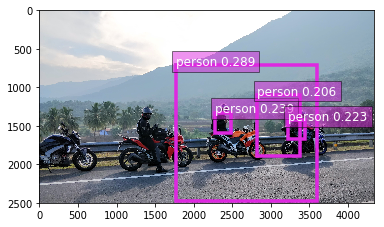

In [47]:
object_categories = ['person', 'bicycle', 'car',  'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 
                     'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog',
                     'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag',
                     'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat',
                     'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
                     'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot',
                     'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable',
                     'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven',
                     'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
                     'toothbrush']
# Setting a threshold 0.20 will only plot detection results that have a confidence score greater than 0.20.
threshold = 0.20

# Visualize the detections.
visualize_detection(file_name, detections, object_categories, threshold)

In [48]:
sagemaker.Session().delete_endpoint(object_detector.endpoint)

INFO:sagemaker:Deleting endpoint with name: object-detection-2018-07-20-10-28-59-064
